In [12]:
# !pip install tensorflow_datasets==4.3

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature
from sklearn import neighbors
# from google.colab.patches import cv2_imshow

In [14]:
(train_ds_raw, test_ds_raw), metadata = tfds.load(
    'deep_weeds',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)


In [15]:
get_label_name = metadata.features['label'].int2str
def visualize(image, label):
  _ = plt.imshow(image)
  _ = plt.title(get_label_name(label))

# helpers
def compare(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

def downsampling(x, y):
  return (tf.image.resize(x, [128, 128]), y)

In [16]:
# downsample
# train_ds = train_ds_raw.map(downsampling)
# test_ds = test_ds_raw.map(downsampling)

train_ds = train_ds_raw
test_ds = test_ds_raw

In [17]:
train_ds_numpy = [(example.numpy(), label.numpy()) for example, label in train_ds if label < 8]
test_ds_numpy = [(example.numpy(), label.numpy()) for example, label in test_ds if label < 8]

X_train_original = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test_original = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

In [6]:
# x_train_normalized = list(map(lambda image: np.rint(255.0 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(image.dtype), x_train))
# x_test_normalized = list(map(lambda image: np.rint(255.0 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(image.dtype), x_test))

In [7]:
# i = 0
# visualize(x_train_normalized[i], y_train[i])
# compare(x_train[i], x_train_normalized[i])

In [8]:
from tensorflow.keras.applications import VGG16

img_width, img_height = X_train_original[0].shape[0:2]
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [9]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(x, y):
    sample_count = len(y)
    
    features = np.zeros(shape=(sample_count, 8, 8, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow(np.array(x), np.array(y), batch_size = batch_size)
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        print(features_batch.shape)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(X_train_original, y_train)  # Agree with our small dataset size
# validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(X_test_original, y_test)

(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 

In [10]:
X_train = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(6672,)
feature size now: (32768,)


In [11]:
n_neighbors = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
accuracy = knn.score(X_test, y_test)

In [12]:
print(accuracy)

0.5343731946851531


In [ ]:
x_train_gray = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), x_train_normalized))
x_test_gray = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), x_test_normalized))

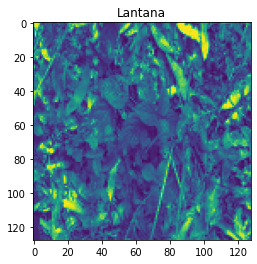

In [ ]:
i = 0
visualize(x_train_gray[i], y_train[i])

In [ ]:
gray = x_train_gray[0]
gray_label = y_train[0]

In [ ]:
x_train_gray_flattened = list(map(lambda x: x.flatten(), x_train_gray))
x_test_gray_flattened = list(map(lambda x: x.flatten(), x_test_gray))

In [ ]:
print(np.array(x_train_gray_flattened).shape)

(6672, 16384)


In [ ]:
from sklearn.model_selection import KFold

def kfold_cross_validation(k, train_X, train_Y, n_neighbors):
  print(f'Running {k}-fold cross validation for n_neighbors: {n_neighbors}')
  kf = KFold(n_splits=k)

  accuracies = []
  models = []
  best_performing_idx = 0
  best_performing_acc = 0
  i = 0

  for train_index, test_index in kf.split(train_X):
    print(f'train_index: {train_index}, test_index: {test_index}')
    cf_train_X = [train_X[index] for index in train_index]
    cf_train_Y = [train_Y[index] for index in train_index]
    cf_test_X = [train_X[index] for index in test_index]
    cf_test_Y = [train_Y[index] for index in test_index]
    accuracy, model = run_knn(cf_train_X, cf_train_Y, cf_test_X, cf_test_Y, n_neighbors)
    accuracies.append(accuracy)
    models.append(model)
    print(f'accuracy for {str(n_neighbors)} is: {str(accuracy)}')
    if (accuracy > best_performing_acc):
      best_performing_acc = accuracy
      best_performing_idx = i
    
    i += 1

  assert(len(accuracies) == k)
  average_accuracy = sum(accuracies) / k
  print(f'Completed {k}-fold cross validation for n_neighbors: {n_neighbors}')
  print(f'Obtained average accuracy of: {average_accuracy}')

  # train with best performing model
  final_accuracy = models[best_performing_idx].score(x_test, y_test)
  print(f'Obtained final accuracy of: {final_accuracy}')
  return final_score

In [ ]:
def run_knn(train_X, train_Y, test_X, test_Y, n_neighbors):
  knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(train_X, train_Y)
  accuracy = knn.score(test_X, test_Y)
  return (accuracy, knn)

In [ ]:
n_neighbors_arr = [5, 10, 15, 20]
k = 5
final_accuracies = []
for n_neighbors in n_neighbors_arr:
  final_accuracy = kfold_cross_validation(k, x_train_gray_flattened, y_train, n_neighbors)
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for n_neighbors: 5
train_index: [1335 1336 1337 ... 6669 6670 6671], test_index: [   0    1    2 ... 1332 1333 1334]


In [ ]:
print(accuracies)

[0.18139803581744657, 0.18082033506643558, 0.18197573656845753, 0.1779318313113807]
